## Brain Tumor Detection

- libraries

In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, Activation, MaxPooling2D
from keras.layers import Input, concatenate, Conv2DTranspose
from keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

- data gathering

In [2]:
images_dir = "../data/brain_tumor/datasets/"

In [3]:
no_tumor_images = os.listdir(images_dir+ "no/")
print(len(no_tumor_images))

tumor_images = os.listdir(images_dir+ "yes/")
print(len(tumor_images))

1500
1500


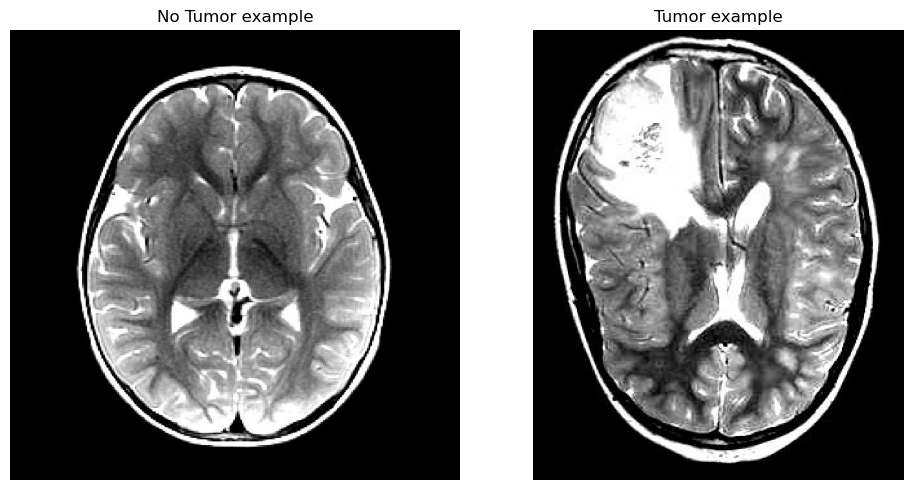

In [4]:
no_tumor_image_path = os.path.join(images_dir, "no", no_tumor_images[0])
tumor_image_path = os.path.join(images_dir, "yes", tumor_images[0])

no_tumor_image = Image.open(no_tumor_image_path)
tumor_image = Image.open(tumor_image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(no_tumor_image)
ax[0].set_title("No Tumor example")
ax[0].axis("off")
ax[1].imshow(tumor_image)
ax[1].set_title("Tumor example")
ax[1].axis("off")
plt.tight_layout()
plt.show()

In [5]:
dataset = []
labels = []

for i, image_name in enumerate(no_tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image = cv2.imread(images_dir+'no/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((64,64))
        dataset.append(np.array(image))
        labels.append(0)

for i, image_name in enumerate(tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image = cv2.imread(images_dir+'yes/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((64,64))
        dataset.append(np.array(image))
        labels.append(1)

print(len(dataset))
print(len(labels))

3000
3000


In [6]:
dataset = np.array(dataset)
labels = np.array(labels)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(dataset, labels, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_valid.shape)

(2700, 64, 64, 3)
(300, 64, 64, 3)
(2700,)
(300,)


In [8]:
X_train = normalize(X_train, axis=1)
X_valid = normalize(X_valid, axis=1)

- model architecture:

In [9]:
def build_model():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(64, 64, 3)))

    # Convolution blocks
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # flattening the data for Dense layers
    model.add(Flatten())
    
    # fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    # 1 neuron for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

brain_model = build_model()
brain_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,476,417 (9.45 MB)

 Trainable params: 2,476,417 (9.45 MB)

 Non-trainable params: 0 (0.00 B)

- training

In [10]:
def model_training(model, x_train, y_train, x_valid, y_valid):
    # Early stopping 
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=3,
                       restore_best_weights=True,
                       verbose=1)
    
    # Saving best model
    checkpoint_cb = ModelCheckpoint("../models/brain_model_best.keras",
                                    save_best_only=True,
                                    verbose=1)
    
    # Reduce learning rate when the validation loss plateaus
    reduce_lr = ReduceLROnPlateau(monitor='loss',
                                  factor=0.2,
                                  patience=2,
                                  min_lr=1e-5,
                                  mode='min',
                                  verbose=1)
    
    training_history = model.fit(x_train,
                              y_train,
                              epochs=30,
                              batch_size=12,
                              validation_data = [x_valid, y_valid],
                              callbacks=[es, checkpoint_cb, reduce_lr],
                              verbose=1,
                              shuffle=False)
    
    return training_history


In [11]:
# Check for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
training = model_training(brain_model, X_train, y_train, X_valid, y_valid)

brain_model.save('../models/brain_tumor_model.keras')

Epoch 1/30
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5697 - loss: 0.6729
Epoch 1: val_loss improved from inf to 0.54979, saving model to ../models/brain_model_best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5702 - loss: 0.6727 - val_accuracy: 0.7300 - val_loss: 0.5498 - learning_rate: 1.0000e-04
Epoch 2/30
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7176 - loss: 0.5682
Epoch 2: val_loss improved from 0.54979 to 0.50382, saving model to ../models/brain_model_best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7177 - loss: 0.5681 - val_accuracy: 0.7633 - val_loss: 0.5038 - learning_rate: 1.0000e-04
Epoch 3/30
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7524 - loss: 0.5269
Epoch 3: val_loss improved from 0.50382 to 0.46722, saving model to ../models/brain_model_best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7525 - loss: 0.5268 - val_accuracy: 0.7867 - val_loss: 0.4672 - learning_rate: 1.0000e-04
E